# CIFAR-100 画像データを用いた機械学習と画像認識の実験

# はじめに

![cifar100)](https://user-images.githubusercontent.com/5820803/93660941-d8ee0900-fa8e-11ea-9d81-4c17f52c128e.png)

　　　　　　図１　CIAR-100 画像の例

 CIFAR-100は画像認識の研究用画像データセットです。詳しくは[こちら](https://www.atmarkit.co.jp/ait/articles/2006/15/news036.html)

- 5万枚の訓練データ用（画像とラベル）   (train)
- 1万枚のテストデータ用（画像とラベル） (test)  
 
合計6万枚で構成されています。

  これらの画像は動物や乗り物など100カテゴリの被写体のどれかが写った写真です.
 それぞれの被写体の画像は同じ枚数存在します。つまり、訓練データは1種類500枚ずつ、テストデータは100枚ずつとなっています。



# １．準備

まず説明を読みながら「課題」の前まで一通り実行し、実験内容を理解してください。

**GPU**が使えるかどうかで実行時間が大きく変わります。

（説明を読んで理解する時間を除いて）すべてのプログラムの実行に要する時間は次のとおりです。
- GPUが使える場合　約５分      
- CPUのみで実行した場合　約15分

「**ランタイム**」メニューの「**ランタイムのタイプを変更**」でハードウェアアクセラレータとして**GPU**を選べばGPUが使えます。

ただし、混雑している時間帯などには、設定でGPUを選んでも、GPUが割り当てられないことがあります。

データセットの読み込みや学習に時間がかかります。その間に次の説明を読み進めるようにしてください。

## 1.1　ライブラリのインポート、データの読み込み、サポート関数の定義
- ライブラリの読み込み
- データセットの読み込み
- 表示用関数の定義

#### <font color='red'>　実行方法</font>
各セルの左上の ▶ マークをクリックするか、実行したいセルをクリックして**Shift+Enter** でそのセル内のプログラムが実行されます。

インタラクティブに実行を進めますが、あくまでも python プログラムなので、基本的に上から順に実行する必要があります。

次のセルでは、実行に必要なライブラリの読み込みを行います。最初に必ず1度実行する必要があります。2度実行する必要はありません。

#### <font color='red'>　行き詰まったら</font>

- 最初からやり直したい場合は、「ランタイム」メニューの「ランタイムを再起動」を実行してください。そうすれば初期化されます。（ただし、書き換えたコードはもとには戻りません）
- コードの書き換えで間違ったりしてわからなくなった場合は、新たにファイルをアップロードして別のノートを作ってやり直してください。

In [1]:
!pip -q install japanize-matplotlib
!wget -q https://github.com/iciromaco/MLLesson/raw/master/ML08%20%E4%B8%80%E8%88%AC%E7%89%A9%E4%BD%93%E8%AA%8D%E8%AD%98/cifar-100/CifarLib.py
from sklearn import svm, metrics
# from sklearn.model_selection import StratifiedShuffleSplit

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,Dense, Activation
from tensorflow.keras.layers import MaxPool2D #,AveragePooling2D
from tensorflow.keras.optimizers import Adam #, SGD
from tensorflow.keras.layers import Dropout, Flatten, GlobalAveragePooling2D,BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger,TensorBoard
from tensorflow.keras.utils import plot_model, to_categorical
from keras.callbacks import TensorBoard

from keras.datasets import cifar100
from tensorflow import keras
import tensorflow as tf

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import japanize_matplotlib
from PIL import Image
import math
from IPython.display import display_png
from IPython.display import Image as IPImage

from CifarLib import * # 独自ライブラリ

SIZE = 32
CLASSES = 3 # カテゴリ数
DATASIZE = SIZE *  SIZE * 3

# データセットの読み込み
(X_train, y_train),(X_test, y_test) = cifar100.load_data()


     |████████████████████████████████| 4.1 MB 7.7 MB/s 
169017344/169001437 [==============================] - 4s 0us/step


# 1.2 データの確認

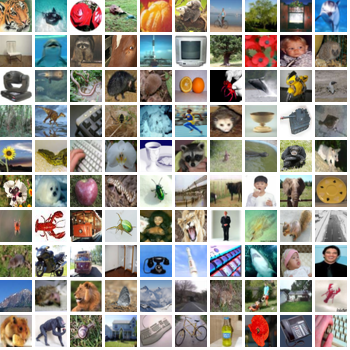

In [2]:
# テストデータの124番から100枚表示
showimages(X_train,124)

#### The CIFAR-100 dataset

最初のセルの実行でデータセットの読み込みを行っており、配列変数 **(X_train,y_train)、(X_test,y_test)** にデータが格納されています。

**X_train[n]**と**X_test[n]**が、それぞれn番目の訓練用画像とn番目のテスト用画像で、**y_train[n]**、**y_test[n]**にその画像の正解番号（０～９９）が入っています。

CIFAR100 の100のカテゴリーを次の表に示します。

|大分類|カテゴリー|
|:--:|:--|
|花|ラン,ヒマワリ,チューリップ,バラ,ポピー|
|キッチン用具|ボトル,ボウル,缶,カップ,プレート|
|果物・野菜|リンゴ,オレンジ,ナシ,ピーマン,キノコ|
|家電|時計,キーボード,ランプ,電話,テレビ|
|家具|ベッド,椅子,ソファー,タンス,テーブル|
|大型肉食獣|クマ,ヒョウ,ライオン,トラ,オオカミ|
|草食・雑食獣|ラクダ,ウシ,チンパンジー,ゾウ,カンガルー|
|中型哺乳類|キツネ,ヤマアラシ,フクロネズミ,スカンク,ラクーン|
|小型哺乳類|ハムスター,マウス,トガリネズミ,ウサギ,リス|
|昆虫|蜂,甲虫,蝶,いも虫,ゴキブリ|
|爬虫類|クロコダイル,恐竜,トカゲ,カメ,ヘビ|
|水棲哺乳類|ビーバー,イルカ,カワウソ,クジラ,アザラシ|
|魚類|観賞魚,ヒラメ,エイ,エイ,サメ,マス|
|構造物|橋,城,超高層ビル,家,道路|
|無脊椎動物|クモ,カタツムリ,カニ,ロブスター,ミミズ|
|シーン|雲,森林,山,平原,海|
|人間|赤ちゃん,男の子,女性,女の子,男性|
|樹木|カエデ,カシ,マツ,ヤナギ,ヤシ|
|車両１|自転車,バス,列車,ピックアップトラック,オートバイ|
|車両２|芝刈り機,ロケット,路面電車,タンク,トラクター|







画像を確認するための関数を用意しました。次のコードで訓練データ中のイルカの画像が100枚表示されます。250は250番目のイルカ画像から始めて100枚という意味です。

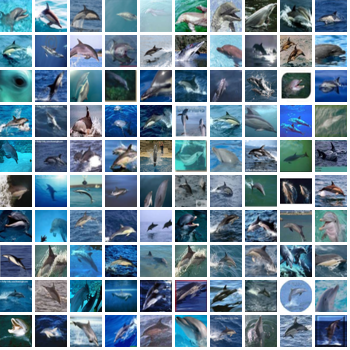

In [3]:
# 訓練データ（X_train）からイルカを抽出して100枚表示
showimages(getCatJ(X_train,y_train,'イルカ'),250)

# ２．実験用データの選択

CIFAR-100は一般画像認識用としてはもっともサイズの小さい部類のデータセットですが、それでも機械学習はとても時間がかかるので、全部を対象に学習させると何時間もかかってしまいます。

そこで、この実験では、１００のカテゴリから３カテゴリだけを選び、訓練用から3カテゴリそれぞれ１００枚を抜き出して学習させ、テスト用の１００枚で結果を評価することにします。

次のセルを実行すると、
- cat1 = 'オレンジ'   （→ dset1 に格納）
- cat2 = 'リンゴ'   　（→ dset2 に格納）
- cat3 ='ピーマン'    （→ dset3 に格納）

のデータが抽出されます。

最初はこの３種で一通り実験を行って要領を理解してください。

In [4]:
cat1,cat2,cat3 = 'オレンジ','リンゴ','ピーマン'
dset1 = getCatJ(X_train,y_train,cat1)[0:100] #  オレンジの画像100枚の配列 訓練用
dset2 = getCatJ(X_train,y_train,cat2)[0:100] #  リンゴの画像100枚の配列 訓練用
dset3 = getCatJ(X_train,y_train,cat3)[0:100] #  ピーマンの画像100枚の配列 訓練用
tset1 = getCatJ(X_test,y_test,cat1) #  オレンジの画像100枚の配列 テスト用
tset2 = getCatJ(X_test,y_test,cat2) #  リンゴの画像100枚の配列 テスト用
tset3 = getCatJ(X_test,y_test,cat3) #  ピーマンの画像100枚の配列 テスト用
Xtrain = (np.r_[dset1,dset2,dset3].astype('float32'))/255
ytrain = np.array([0]*100+[1]*100+[2]*100).astype('float32') 
Xtest = (np.r_[tset1,tset2,tset3].astype('float32'))/255
ytest = ytrain.copy()
# 訓練データをシャッフルする
p = np.random.permutation(len(Xtrain))    # ランダムなインデックス順の取得
Xtrain, ytrain = Xtrain[p], ytrain[p]

# 各カテゴリの画像の確認

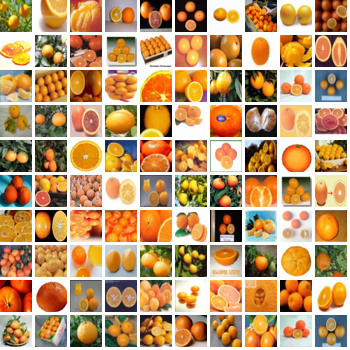

In [5]:
showimages(dset1)

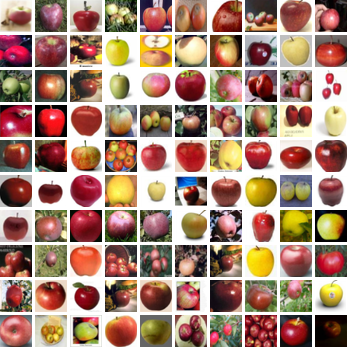

In [6]:
showimages(dset2)

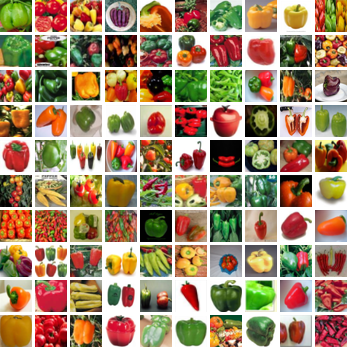

In [7]:
showimages(dset3)

# ３．学習実験

データの準備が整ったので、学習のフェーズに進みましょう。

# 3.1 SVM　サポートベクターマシン
**SVM（サポートベクタマシン）**は深層学習が登場するまでは、最強とされていた統計的機械学習法です。
まず、SVMでどの程度認識率が得られるかを試しておきます。

SVMには識別面が超平面に限定される**線形SVM**と、曲面を識別面とすることのできる**非線形SVM**があります。両方試してみましょう。

In [8]:
%%time
clfL = svm.LinearSVC(max_iter=10000)
clf = svm.SVC(max_iter=-1)
XtrainFlat = Xtrain.reshape(len(Xtrain),DATASIZE)
XtestFlat = Xtest.reshape(len(Xtest),DATASIZE)
clfL.fit(XtrainFlat, ytrain)
clf.fit(XtrainFlat, ytrain)
print("線形SVM") #
print("　訓練用画像での正答率{:5.4f}%".format(clfL.score(XtrainFlat, ytrain)*100)) #
print("　テスト用画像での正答率{:5.4f}".format(clfL.score(XtestFlat, ytest)*100)) # 
print("非線形SVM") #
print("　訓練用画像での正答率{:5.4f}%".format(clf.score(XtrainFlat, ytrain)*100)) # 
print("　テスト用画像での正答率{:5.4f}".format(clf.score(XtestFlat, ytest)*100)) # 

線形SVM
　訓練用画像での正答率100.0000%
　テスト用画像での正答率49.6667
非線形SVM
　訓練用画像での正答率89.0000%
　テスト用画像での正答率63.0000
CPU times: user 22 s, sys: 116 ms, total: 22.1 s
Wall time: 22 s


**線形SVM**は、訓練用画像は完璧に識別できる代わりに,'オレンジ','リンゴ','ピーマン'のテスト用画像では正答率約50％、２つに１つ間違います。しかし、３択問題なのでランダムに答えを選んだ場合の理論的な正答率33％です。それよりは高い値なので、学習の効果があると言えます。

**非線形SVM**は訓練用画像でも10％ほど間違ってしまいますが、テスト画像での正答率が63％ですからも、３つに１つぐらいしか間違わないという結果となります。

この結果はデフォルト設定での結果であり、チューニングしてやればすればもう少し改善できるでしょう。

なお、正解率は選んだカテゴリによって大きく変化します。

# 3.2 model1 ３層バックプロパゲーションネット

入力層、中間層、出力層、各１層ずつからなる、もっとも基本的なニューラルネットワークを**モデル１**として、どの程度のパフォーマンスが得られるか試してみます。


### モデルの構造定義

python用の機械学習ライブラリは何種類もありますが、このプログラムでは、Google が公開している **Tensorflow-Keras**というライブラリを利用しています。Keras で中間層１の全結合ニューラルネットワークの構造は次のように記述できます。

```
# ３層バックプロパゲーションネットのモデル定義
Sequential([
      Dense(64,activation='relu',input_shape=(DATASIZE,)), # 中間層は全結合で64ノード
      Dense(CLASSES, activation='softmax')]) # 出力層は全結合で３ノード、softmax出力
```

**Sequential** 単純に層を並べただけの単純な階層型ネットワークであることを意味します。   
**Dense()** 全結合層    
**input_shape** 入力データの構造。上のプログラムでは、画素データすべてがフラットに並んだ構造を指定しています。

<font color="darkgreen">深層学習のプログラムには、この構造定義に加えて様々なハイパーパラメータの設定が必要です。１から全部設定して学習プログラムを記述すると複雑でわかりにくくなるので、この実験では最小限の記述だけで実験を進められるように　NNModel というクラスを用意しました。興味のある人は、CifarLib.pyを解読してください</font>

学習器 model1 のインスタンスを作ります。

In [9]:
# ３層バックプロパゲーションネットのモデル定義
NN1 = Sequential([
      Dense(64,activation='relu',input_shape=(DATASIZE,)), # 中間層は全結合で64ノード
      Dense(CLASSES, activation='softmax')]) # 出力層は全結合で３ノード、softmax出力

CATLIST=[cat1,cat2,cat3] # カテゴリのリスト　（3カテゴリ限定）
DSET = (Xtrain,ytrain,Xtest,ytest) # データセット
model1 = NNModel(model=NN1,catlist=CATLIST,dset=DSET,type='MLP') # 学習モデルのインスタンス生成
model1.summary() # モデルの概要表示

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                196672    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 195       
Total params: 196,867
Trainable params: 196,867
Non-trainable params: 0
_________________________________________________________________


Total params の値は、このモデルに含まれるパラメータ数、すなわち重み変数の数です。こんな単純なモデルでも、約20万個のパラメータあります。その値を調整することが、ニューラルネットワークの学習なのです。

講義では説明を簡単にするために２次元か３次元で図示していますが、このモデルの場合だと約20万次元の最適化問題を解かないといけないということです。

次の関数で、層構造の概要が示されます。

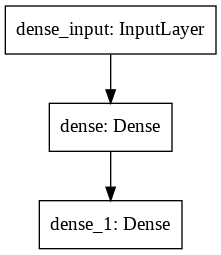

In [10]:
# ネットワーク構造の概観
model1.plot('model1.png')
display_png(IPImage('model1.png'))

### 学習
model1 に学習させてみましょう。

In [ ]:
# 学習
model1.learn(verbose=1,epochs=100)

- **verbose** 途中経過の表示の程度。0とすると経過を表示しなくなる。   
- **epochs** 学習回数。 100 なら全データを使った重み調整を100回繰り返すことを意味する。

なお、誤差が減らなくなった場合は指定した回数に達していなくても繰り返しを打ち切ります。

<font color='red'>（注意）learn を２度実行すると、追加学習になります。最初からやり直したい場合は、「学習器 model1 のインスタンスを作ります。」のセルからやり直してください。</font>

### 結果の意味
- <font color='red'> **loss**</font> : 教師データと結果の差の誤差   
- <font color='red'> **accuracy**</font> : 正解率     

学習中に出力されている誤差と正解率は訓練データに対するものです。通常は誤差は０、正解率は１（100%)に近づいていきます。

学習過程をグラフ化しておきましょう。

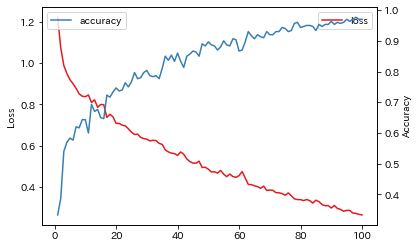

In [12]:
# 学習過程のグラフ化
model1.hplot()

## モデルの評価

In [13]:
# モデルの評価
model1.recognitionResult()

訓練データの認識率
誤認識 6/300 
　正答率= 98.0　誤り率＝  2.0 %

カテゴリごとの認識結果と正答率


,オレンジ,リンゴ,ピーマン,正答率
正解カテゴリ,,,,
オレンジ,100,0,0,100.0
リンゴ,2,97,1,97.0
ピーマン,3,0,97,97.0



テストデータの認識率
誤認識 122/300 
　正答率= 59.3　誤り率＝ 40.7 %

カテゴリごとの認識結果と正答率


,オレンジ,リンゴ,ピーマン,正答率
正解カテゴリ,,,,
オレンジ,65,22,13,65.0
リンゴ,17,69,14,69.0
ピーマン,29,27,44,44.0


モデル１は訓練用データはほぼ正解するようになりますが、テストデータの正答率は６割程度となるはずです。
（ランダム性があるので、性能は前後します。また、カテゴリの組み合わせが変われば結果は大きく変化します）

この３カテゴリでは、ピーマンの正答率がリンゴ、オレンジよりかなり低くなります。

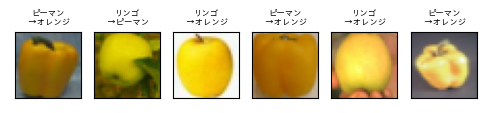

In [14]:
# 訓練データで間違った画像（最大１６まで表示）
model1.showErrorImages(mode = 'train')

下に示す例を含め 122 枚


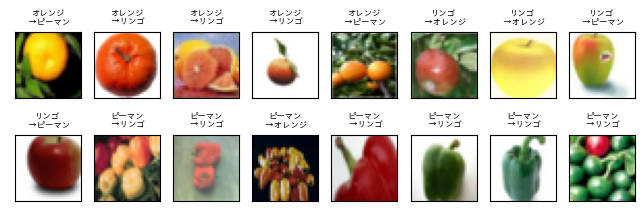

In [15]:
# テストデータで間違った画像の例（最大１６まで表示）
model1.showErrorImages(mode = 'test')

# 3.3  model2　典型的なCNN

典型的な畳み込みニューラルネットワークを試してみましょう。

次のような層構造の深層ネットワークを構成します。

1. ３ｘ３畳み込み　64チャネル 　 -> (32x32)x64チャネル
2. ３ｘ３畳み込み　64チャネル 　 -> (32x32)x64チャネル
3. max pooling 2x2 -> (16x16)x64チャネル
4. ３ｘ３畳み込み　64チャネル　 -> (16x16)x64チャネル
5. ３ｘ３畳み込み　32チャネル　 -> (16x16)x64チャネル
6. max pooling 2x2 -> (8x8)x64チャネル
7. BachNormalization
8. 256ノード全結合 -> 256ノード
9. Dropout
9. 64ノード全結合 -> ノード
10. 3ノード全結合 -> 3ノード 

畳み込み層と出力層以外の全結合層の活性化関数としては ReLU関数を用いる。出力層は  softmax 関数を通して出力。


## モデル定義

In [16]:
# Model 2
NN2 = Sequential([
    Conv2D(64, kernel_size=(3, 3),input_shape=(SIZE, SIZE,3), activation='relu',padding='same'),
    Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same'),
    MaxPool2D(pool_size=(2, 2)),
    BatchNormalization(),
    Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same'),
    Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same'),
    MaxPool2D(pool_size=(2, 2)),
    BatchNormalization(),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(CLASSES, activation='softmax')])

# CATLIST=[cat1,cat2,cat3] # カテゴリのリスト　（3カテゴリ限定）
# DSET = (Xtrain,ytrain,Xtest,ytest) # データセット
model2 = NNModel(model=NN2,catlist=CATLIST,dset=DSET,type='CNN') # 学習モデルのインスタンス生成
model2.summary() # モデルの概要表示

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)         

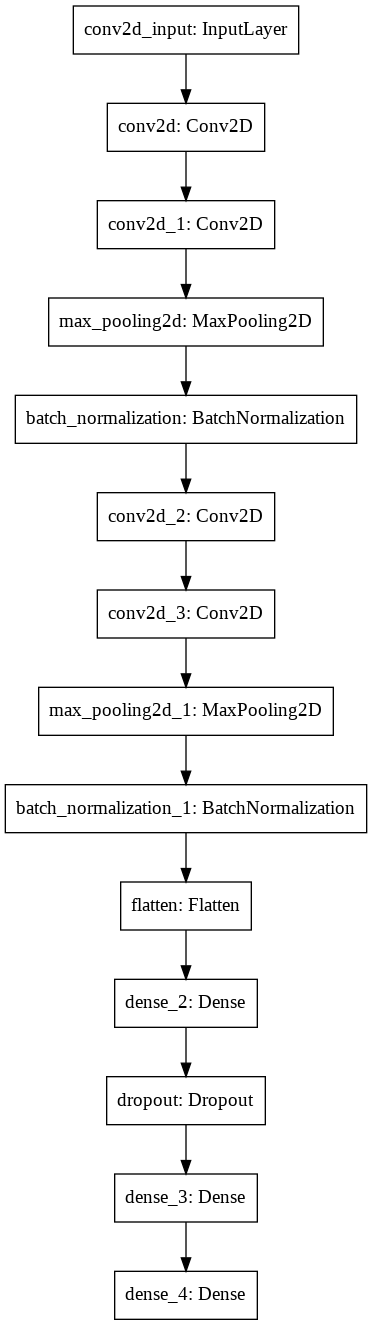

In [17]:
# ネットワーク構造の概観
model2.plot('model2.png')
display_png(IPImage('model2.png'))

In [ ]:
# 学習
model2.learn(verbose=1,epochs=100)

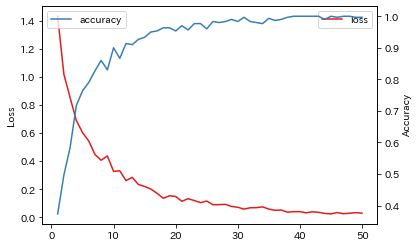

In [19]:
# 学習過程のグラフ化
model2.hplot()

In [20]:
# モデルの評価
model2.recognitionResult()

訓練データの認識率
誤認識 45/300 
　正答率= 85.0　誤り率＝ 15.0 %

カテゴリごとの認識結果と正答率


,オレンジ,リンゴ,ピーマン,正答率
正解カテゴリ,,,,
オレンジ,74,26,0,74.0
リンゴ,0,100,0,100.0
ピーマン,0,19,81,81.0



テストデータの認識率
誤認識 133/300 
　正答率= 55.7　誤り率＝ 44.3 %

カテゴリごとの認識結果と正答率


,オレンジ,リンゴ,ピーマン,正答率
正解カテゴリ,,,,
オレンジ,41,53,6,41.0
リンゴ,1,98,1,98.0
ピーマン,11,61,28,28.0


# 3.4 model3　グローバルプーリングを用いたCNN

従来、畳込みニューラルネットワークは出力層側に数層の全結合層を設けるのが一般的でしたが、全結合はパラメータ数が膨大になります。たとえば、モデル２は約64万パラメータですが、そのうち50万以上は全結合層のパラメータであり、学習時間のほとんどはその部分の調整に費やされていることになります。

最近、全結合層をグローバルプーリング層（GlobalAveragePooling2D）に置き換えたネットワークの利用が流行っています。

普通のプーリングは、畳み込みニューラルネットワークにおいて、１チャネル中の２ｘ２＝４つのデータをその平均値や最大値に集約する処理を言いますが、グローバルプーリングは大胆にも１チャネル全体の平均を取って、１チャネルをたった１データに集約する処理です。

たとえばモデル２では、全結合層の直前でサイズ(8x8)のチャネルが64チャネル、計4096のノードがありますが、グローバルプーリングではそれを各チャネル１ノード、計64ノードに集約します。

結果として、そこから出力までの間のパラメータ数は64分の１に減ります。

問題は、それがパフォーマンスにどう影響するかです。

ということで、実際に試してみましょう。


In [21]:
# Model 3
NN3 = Sequential([
    Conv2D(64, kernel_size=(3, 3),input_shape=(SIZE, SIZE,3), activation='relu',padding='same'),
    Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same'),
    MaxPool2D(pool_size=(2, 2)),
    BatchNormalization(),
    Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same'),
    Conv2D(64, kernel_size=(3, 3), activation='relu',padding='same'),
    MaxPool2D(pool_size=(2, 2)),
    #BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(CLASSES, activation='softmax')])

# CATLIST=[cat1,cat2,cat3] # カテゴリのリスト　（3カテゴリ限定）
# DSET = (Xtrain,ytrain,Xtest,ytest) # データセット
model3 = NNModel(model=NN3,catlist=CATLIST,dset=DSET,type='CNN') # 学習モデルのインスタンス生成
model3.summary() # モデルの概要表示

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)         

|モデル|パラメータ数|
|:--:|:--:|
|model2|645,955|
|model3|113,027|

パラメータ数の違いが顕著です。

In [ ]:
# 学習
model3.learn(verbose=1,epochs=100)

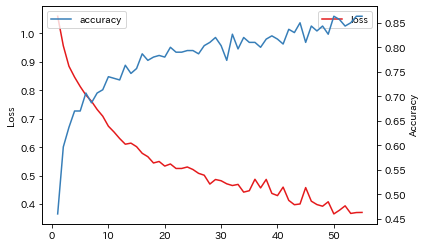

In [23]:
model3.hplot()

In [24]:
model3.recognitionResult()

訓練データの認識率
誤認識 43/300 
　正答率= 85.7　誤り率＝ 14.3 %

カテゴリごとの認識結果と正答率


,オレンジ,リンゴ,ピーマン,正答率
正解カテゴリ,,,,
オレンジ,83,3,14,83.0
リンゴ,0,91,9,91.0
ピーマン,6,11,83,83.0



テストデータの認識率
誤認識 79/300 
　正答率= 73.7　誤り率＝ 26.3 %

カテゴリごとの認識結果と正答率


,オレンジ,リンゴ,ピーマン,正答率
正解カテゴリ,,,,
オレンジ,78,8,14,78.0
リンゴ,5,79,16,79.0
ピーマン,13,23,64,64.0


model2 と model3 を比較してみましょう。

ただし、学習結果は乱数に左右されるので、同じカテゴリであっても常に同じ結果になるわけではありません。**１度の実験だけで、どちらがよい、と断言してはいけません**。モデル定義に戻って何度か実験を繰り返してから結論を出すようにしてください。

モデル２とモデル３の誤答例を示しておきます。


下に示す例を含め 133 枚


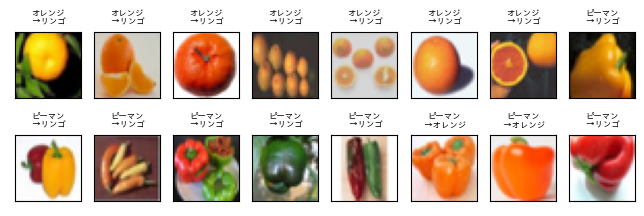

In [25]:
# テストデータで間違った画像の例（モデル２）
model2.showErrorImages(mode = 'test')

下に示す例を含め 79 枚


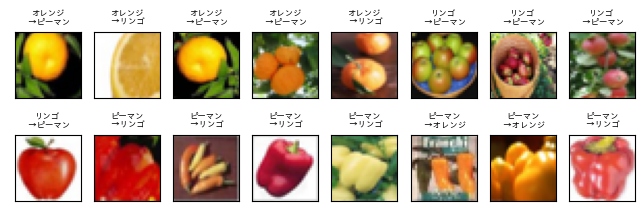

In [26]:
# テストデータで間違った画像の例（モデル３）
model3.showErrorImages(mode = 'test')

# 3.5 model4 転移学習

コンテストで上位に入ったモデルなどの学習済みデータがネット上に公開されています。

その一部を自分のモデルに組み込み、それをもとに学習させることを**転移学習**と言います。

極端な話、リンゴ、オレンジ、ピーマンを含む１００種の野菜や果物を１００％識別可能な学習済みモデルがあるとしたら、それをもとにして学習を行えば、リンゴ、オレンジ、ピーマンの３カテゴリを１００％識別するのは容易でしょう。（ほぼチートです）

ここでは、**MobileNetV2** という、モバイル端末向けの学習済みモデルをベースにして独自モデルを作ってみることにします。


# MobileNetV2 概観

まず、MobileNetV2 がどんな構造なのか見ておきます。

In [27]:
# MobileNetV2 の出力部分を除いたモデル定義を再利用し、重みは、最後の部分以外はImagenet用の学習済み重みを転用する
mnv2 = keras.applications.MobileNetV2(input_shape=(96,96,3),
                                               include_top=False, 
                                               weights='imagenet')
# MobileNetV2 流用部分の構造確認
mnv2.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_96"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 48, 48, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 48, 48, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 48, 48, 32)   0           bn_Conv1[0][0]                   
_________________

**include_top=False**とすると、全結合層がカットされた部分が得られます。Trueにするとわかりますが、実際には、このあとにGlobalPooling層があって、最後に1,000出力の出力層があります。

私達のネットワークは３出力なので、このネットワークの最後に、GlobalPooling層と３ノードの出力層を追加したものを、**model4** として定義します。

In [28]:
NN4 = Sequential([
    mnv2,
    GlobalAveragePooling2D(),
    Dense(CLASSES, activation='softmax')
])

# CATLIST=[cat1,cat2,cat3] # カテゴリのリスト　（3カテゴリ限定）
# DSET = (Xtrain,ytrain,Xtest,ytest) # データセット
model4 = NNModel(model=NN4,catlist=CATLIST,dset=DSET,type='CNN±1',reshape=(96,96)) # 学習モデルのインスタンス生成
model4.summary() # モデルの概要表示

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Functio (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 3843      
Total params: 2,261,827
Trainable params: 2,227,715
Non-trainable params: 34,112
_________________________________________________________________


In [ ]:
# 学習
model4.learn(verbose=1,epochs=100)

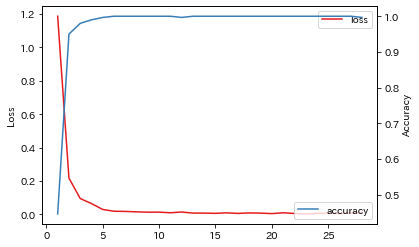

In [30]:
# 学習過程のグラフ化
model4.hplot()

In [31]:
model4.recognitionResult()

訓練データの認識率
誤認識 41/300 
　正答率= 86.3　誤り率＝ 13.7 %

カテゴリごとの認識結果と正答率


,オレンジ,リンゴ,ピーマン,正答率
正解カテゴリ,,,,
オレンジ,100,0,0,100.0
リンゴ,18,82,0,82.0
ピーマン,18,5,77,77.0



テストデータの認識率
誤認識 71/300 
　正答率= 76.3　誤り率＝ 23.7 %

カテゴリごとの認識結果と正答率


,オレンジ,リンゴ,ピーマン,正答率
正解カテゴリ,,,,
オレンジ,98,1,1,98.0
リンゴ,18,79,3,79.0
ピーマン,34,14,52,52.0


下に示す例を含め 41 枚


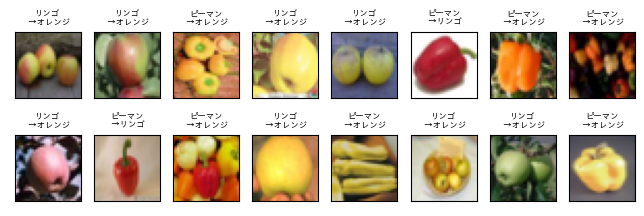

In [32]:
model4.showErrorImages(mode = 'train')

下に示す例を含め 71 枚


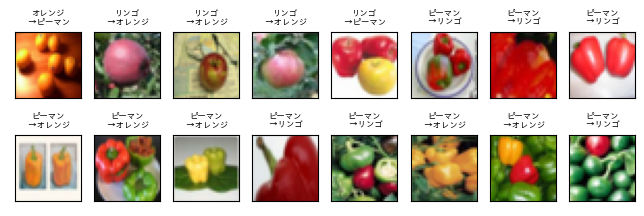

In [33]:
model4.showErrorImages(mode = 'test')

# <font color='red'>課題</font>


* 例以外の３つのカテゴリで同じ実験を行い、結果をまとめて報告する。（複製を作って実行するとよい）
* カテゴリは適当に３つ選ぶのではなく、なんらかの意図をもって、結果が予想できるような組み合わせにすること。レポートにその組み合わせを選んだ理由を述べること。
* 結果についての考察を述べること。（感想は不要）

課題については、別に添付されている資料も参照すること。







# （付録）その他の利用可能な学習済みモデル

Keras ライブラリで簡単に読み込み可能な学習済みモデル

|Model|サイズ|1位の精度|Top-5 精度|パラメータ数|層数|
|:--:|---:|:--:|:--:|---:|---:|
|Xception|88 MB|0.790|0.945|22,910480|126|
|VGG16|528 MB|0.715|0.901|138,357,544|23|
|VGG19|549 MB|0.727|0.910|143,667,240|26|
|ResNet50|99 MB|0.759|0.929|25,636,712|168|
|InceptionV3|92 MB|0.788|0.944|23,851,784|159|
|InceptionResNetV2|215 MB|0.804|0.953|55,873,736|572|
|MobileNet|17 MB|0.665|0.871|4,253,864|88|
|DenseNet121|33 MB|0.745|0.918|8,062,504|121|
|DenseNet169|57 MB|0.759|0.928|14,307,880|169|
|DenseNet201|80 MB|0.770|0.933|20,242,984|201|

- https://keras.io/ja/applications/

-CPUのみで計算する場合、計算時間はパラメータ数に比例すると考えればよい。   
-GPUが使えれば数分の１の時間で学習が済むので、まず、ランタイムメニューでランタイムのタイプをGPUにセットして試せばよい。GPUが使えればラッキー

参考までに、CPUの場合、VGG16での学習は30分以上かかったが、テストデータでの精度は77％程度となった。Xceptionの場合は80％程度の精度が得られる。（チューリップ、バラ、ヒマワリの場合の結果）

## 他の学習済みモデルの試し方

```
# MobileNetV2 の出力部分を除いたモデル定義を再利用し、重みは、最後の部分以外はImagenet用の学習済み重みを転用する
mnv2 = keras.applications.MobileNetV2(input_shape=(96,96,3),
                                               include_top=False, 
                                               weights='imagenet')
```

という部分を、**Xception** ならば、

```
mnv2= keras.applications.Xception(input_shape=(96,96,3),
                                               include_top=False,
                                               weights='imagenet')  
```

**VGG16** ならば、

```
mnv2 = keras.applications.VGG16(input_shape=(64,64,3),
                                               include_top=False,
                                               weights='imagenet')  
```
等と書き換えればいいです。
